In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Wed May 26 02:39:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   60C    P0   230W / 250W |  29861MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   

## Setup imports

In [2]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-134-generic)
Numpy version: 1.18.5
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.51.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [3]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [4]:
test_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Test/noise20_b50f_5.0/*/*.npy'))
test_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Test/noise100_b50f_5.0/*/*.npy'))

dcm_test_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset_DCM/Test/noise20_b50f_5.0/*/*.dcm"))
dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset_DCM/Test/noise100_b50f_5.0/*/*.dcm"))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                                                                              test_high_images, 
                                                                                                                                              dcm_test_low_images, 
                                                                                                                                              dcm_test_high_images)]

## Augmentation

In [5]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
#         CenterSpatialCropd(keys=["low", "high"], roi_size=(256, 256)),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [6]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Test/noise20_b50f_5.0/CHU_EUL_YEO_M60/CHU_EUL_YEO_M60_001_20210218_180505_00027.npy
/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Test/noise100_b50f_5.0/CHU_EUL_YEO_M60/CHU_EUL_YEO_M60_001_20210218_180353_00027.npy
image shape: torch.Size([512, 512])
tensor(0.2127) tensor(-1.) torch.float32 torch.Size([512, 512])


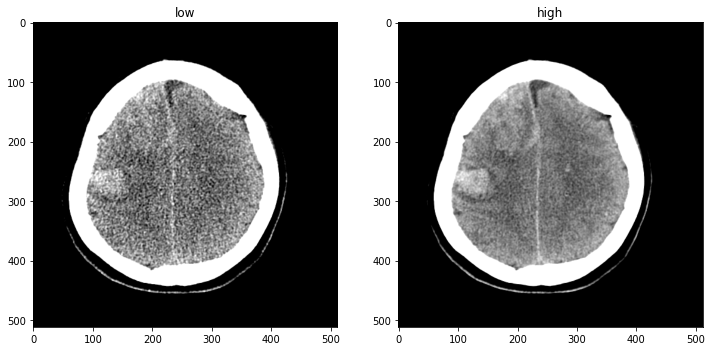

In [7]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")
print(low.max(), low.min(), low.dtype, low.shape)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

## DataLoader

In [8]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=12, drop_last=False)

CPU 갯수 =  32


## Create Model, Loss, Optimizer  Only Low -> High

In [10]:
from Unet_sunggu.model import UNet

device = 'cuda'
model = UNet()      
model.to(device)

UNet(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## 모델 이어서 학습하기

In [27]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/Unet_with_L1Loss/epoch_995_model.pth'
checkpoint = torch.load(checkpoint_dir)
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])

## multi-gpu 사용
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to('cuda')  

print(epoch)

995


## TEST

In [12]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [13]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x): # pydicom에 자동으로 -1024를 해주는 부분이 있어서?
    x = (4095.0)*x
    return x

In [14]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [15]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/test_Unet_L1_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    model.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = model(input_low)

        # 저장하기
#         print(input_low.min(), input_low.max())
#         input_low[:, 128:128+256, 128:128+256, :] = 0
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        input_high_dcm  = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_high)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        input_high  = fn_denorm_window(fn_tonumpy((input_high)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        input_high  = np.clip(input_high, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_high[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/449 [00:00<?, ?it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_low_CHO_HYE_F39_001_20210218_172816_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_high_CHO_HYE_F39_001_20210218_172710_00001.dcm
4109.4346 -4.5565042 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/pred_high_CHO_HYE_F39_001_20210218_172816_00001.dcm
Test:   0%|          | 1/449 [00:01<08:37,  1.15s/it]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_low_CHO_HYE_F39_001_20210218_172816_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_high_CHO_HYE_F39_001_20210218_172711_00002.dcm
4111.076 -6.6141076 float32
/workspace/sunggu/4.Dose_img2

Test:   3%|▎         | 15/449 [00:04<01:39,  4.36it/s]2723.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_low_CHO_HYE_F39_001_20210218_172816_00016.dcm
2722.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_high_CHO_HYE_F39_001_20210218_172711_00016.dcm
2723.937 -0.83670974 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/pred_high_CHO_HYE_F39_001_20210218_172816_00016.dcm
Test:   4%|▎         | 16/449 [00:04<01:40,  4.33it/s]2716.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_low_CHO_HYE_F39_001_20210218_172816_00017.dcm
2693.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_high_CHO_HYE_F39_001_20210218_172711_00017.dcm
2711.1443 -1.1134976 float32
/workspace/sunggu/

Test:   7%|▋         | 30/449 [00:07<01:12,  5.80it/s]2475.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_low_CHO_HYE_F39_001_20210218_172816_00031.dcm
2471.0 3.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_high_CHO_HYE_F39_001_20210218_172711_00031.dcm
2472.9316 7.5640707 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/pred_high_CHO_HYE_F39_001_20210218_172816_00031.dcm
Test:   7%|▋         | 31/449 [00:07<01:08,  6.08it/s]2050.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_low_CHO_HYE_F39_001_20210218_172816_00032.dcm
2044.0 4.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_HYE_F39/gt_high_CHO_HYE_F39_001_20210218_172711_00032.dcm
2051.536 10.462655 float32
/workspac

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173518_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173415_00001.dcm
4123.9395 -3.5591893 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/pred_high_CHO_KYE_HWA_M80_001_20210218_173518_00001.dcm
Test:   8%|▊         | 35/449 [00:07<01:03,  6.56it/s]2831.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173518_00002.dcm
2826.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173415_00002.dcm
2834.547 -1.36783 float32
/workspace/sunggu/4.Dose_img2img/Pr

Test:  11%|█         | 48/449 [00:10<01:25,  4.69it/s]2579.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173518_00015.dcm
2579.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173416_00015.dcm
2580.4211 -1.1398584 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/pred_high_CHO_KYE_HWA_M80_001_20210218_173518_00015.dcm
Test:  11%|█         | 49/449 [00:10<01:27,  4.60it/s]2547.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173518_00016.dcm
2532.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173416_00016.dcm
2544.34

Test:  14%|█▍        | 62/449 [00:13<01:18,  4.93it/s]2141.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173518_00029.dcm
2142.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173416_00029.dcm
2143.198 9.053942 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/pred_high_CHO_KYE_HWA_M80_001_20210218_173518_00029.dcm
Test:  14%|█▍        | 63/449 [00:13<01:16,  5.03it/s]2246.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173518_00030.dcm
2238.0 7.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173416_00030.d

Test:  17%|█▋        | 76/449 [00:16<01:17,  4.80it/s]2591.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173854_00008.dcm
2597.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173747_00008.dcm
2592.325 -0.7473761 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/pred_high_CHO_KYE_HWA_M80_001_20210218_173854_00008.dcm
Test:  17%|█▋        | 77/449 [00:16<01:19,  4.68it/s]2975.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173855_00009.dcm
2977.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173747_00009.dcm
2978.681

Test:  20%|██        | 90/449 [00:19<01:28,  4.05it/s]2488.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173855_00022.dcm
2497.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173747_00022.dcm
2489.5637 -1.2877715 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/pred_high_CHO_KYE_HWA_M80_001_20210218_173855_00022.dcm
Test:  20%|██        | 91/449 [00:20<01:24,  4.25it/s]2404.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_low_CHO_KYE_HWA_M80_001_20210218_173855_00023.dcm
2397.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_KYE_HWA_M80/gt_high_CHO_KYE_HWA_M80_001_20210218_173747_00023.dcm
2402.23

Test:  23%|██▎       | 104/449 [00:22<00:54,  6.35it/s]2913.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_low_CHO_MYE_F71_001_20210218_174230_00001.dcm
2907.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_high_CHO_MYE_F71_001_20210218_174128_00001.dcm
2912.557 -7.330241 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/pred_high_CHO_MYE_F71_001_20210218_174230_00001.dcm
Test:  23%|██▎       | 105/449 [00:22<00:53,  6.39it/s]2797.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_low_CHO_MYE_F71_001_20210218_174230_00002.dcm
2796.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_high_CHO_MYE_F71_001_20210218_174128_00002.dcm
2800.7986 -1.8742981 float32
/workspace/sunggu/

Test:  27%|██▋       | 119/449 [00:25<01:13,  4.49it/s]2626.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_low_CHO_MYE_F71_001_20210218_174230_00016.dcm
2616.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_high_CHO_MYE_F71_001_20210218_174128_00016.dcm
2616.8347 -0.7161337 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/pred_high_CHO_MYE_F71_001_20210218_174230_00016.dcm
Test:  27%|██▋       | 120/449 [00:25<01:13,  4.51it/s]2612.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_low_CHO_MYE_F71_001_20210218_174230_00017.dcm
2619.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_high_CHO_MYE_F71_001_20210218_174128_00017.dcm
2610.1238 -0.13033926 float32
/workspace/sung

Test:  30%|██▉       | 134/449 [00:28<00:48,  6.51it/s]2406.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_low_CHO_MYE_F71_001_20210218_174230_00031.dcm
2400.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_high_CHO_MYE_F71_001_20210218_174128_00031.dcm
2404.869 4.332804 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/pred_high_CHO_MYE_F71_001_20210218_174230_00031.dcm
Test:  30%|███       | 135/449 [00:28<00:45,  6.86it/s]1449.0 6.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_low_CHO_MYE_F71_001_20210218_174230_00032.dcm
1447.0 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_MYE_F71/gt_high_CHO_MYE_F71_001_20210218_174128_00032.dcm
1450.9174 17.228458 float32
/workspa

Test:  33%|███▎      | 148/449 [00:30<01:03,  4.77it/s]2702.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_low_CHO_SEO_LYE_F65_001_20210218_174554_00011.dcm
2685.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_high_CHO_SEO_LYE_F65_001_20210218_174450_00011.dcm
2697.2778 -3.2460334 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/pred_high_CHO_SEO_LYE_F65_001_20210218_174554_00011.dcm
Test:  33%|███▎      | 149/449 [00:31<01:02,  4.84it/s]2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_low_CHO_SEO_LYE_F65_001_20210218_174554_00012.dcm
2653.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_high_CHO_SEO_LYE_F65_001_20210218_174450_00012.dcm
2654.

Test:  36%|███▌      | 162/449 [00:33<00:54,  5.25it/s]2494.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_low_CHO_SEO_LYE_F65_001_20210218_174554_00025.dcm
2482.0 5.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_high_CHO_SEO_LYE_F65_001_20210218_174450_00025.dcm
2491.3494 11.193434 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/pred_high_CHO_SEO_LYE_F65_001_20210218_174554_00025.dcm
Test:  36%|███▋      | 163/449 [00:33<00:53,  5.38it/s]2489.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_low_CHO_SEO_LYE_F65_001_20210218_174554_00026.dcm
2488.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEO_LYE_F65/gt_high_CHO_SEO_LYE_F65_001_20210218_174450_00026.dcm


Test:  43%|████▎     | 191/449 [00:39<00:56,  4.56it/s]2714.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEU_M53/gt_low_CHO_SEU_M53_001_20210218_174926_00022.dcm
2710.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEU_M53/gt_high_CHO_SEU_M53_001_20210218_174820_00022.dcm
2708.9011 -0.64339757 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEU_M53/pred_high_CHO_SEU_M53_001_20210218_174926_00022.dcm
Test:  43%|████▎     | 192/449 [00:39<00:55,  4.64it/s]2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEU_M53/gt_low_CHO_SEU_M53_001_20210218_174926_00023.dcm
2632.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_SEU_M53/gt_high_CHO_SEU_M53_001_20210218_174820_00023.dcm
2639.7915 0.21759823 float32
/workspace/sung

Test:  46%|████▌     | 206/449 [00:42<00:41,  5.87it/s]2746.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_low_CHO_YON_SOO_F65_001_20210218_175404_00003.dcm
2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_high_CHO_YON_SOO_F65_001_20210218_175300_00003.dcm
2744.0818 -5.3365874 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/pred_high_CHO_YON_SOO_F65_001_20210218_175404_00003.dcm
Test:  46%|████▌     | 207/449 [00:42<01:01,  3.95it/s]2780.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_low_CHO_YON_SOO_F65_001_20210218_175404_00004.dcm
2773.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_high_CHO_YON_SOO_F65_001_20210218_175300_00004.dcm
2781.

Test:  49%|████▉     | 220/449 [00:45<00:45,  5.04it/s]2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_low_CHO_YON_SOO_F65_001_20210218_175405_00017.dcm
2673.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_high_CHO_YON_SOO_F65_001_20210218_175300_00017.dcm
2672.7585 -0.54991454 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/pred_high_CHO_YON_SOO_F65_001_20210218_175405_00017.dcm
Test:  49%|████▉     | 221/449 [00:45<00:46,  4.95it/s]2647.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_low_CHO_YON_SOO_F65_001_20210218_175405_00018.dcm
2651.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_high_CHO_YON_SOO_F65_001_20210218_175300_00018.dcm
2645

Test:  52%|█████▏    | 234/449 [00:48<00:47,  4.55it/s]2378.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_low_CHO_YON_SOO_F65_001_20210218_175405_00031.dcm
2368.0 5.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_high_CHO_YON_SOO_F65_001_20210218_175300_00031.dcm
2378.0457 10.511959 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/pred_high_CHO_YON_SOO_F65_001_20210218_175405_00031.dcm
Test:  52%|█████▏    | 235/449 [00:48<00:42,  4.98it/s]1729.0 6.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_low_CHO_YON_SOO_F65_001_20210218_175405_00032.dcm
1727.0 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHO_YON_SOO_F65/gt_high_CHO_YON_SOO_F65_001_20210218_17530

2657.8794 -0.20844519 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/pred_high_CHU_BYE_M49_001_20210218_180117_00012.dcm
Test:  55%|█████▌    | 249/449 [00:51<00:40,  5.00it/s]2708.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/gt_low_CHU_BYE_M49_001_20210218_180117_00013.dcm
2700.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/gt_high_CHU_BYE_M49_001_20210218_180010_00013.dcm
2705.0344 -3.1530385 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/pred_high_CHU_BYE_M49_001_20210218_180117_00013.dcm
Test:  56%|█████▌    | 250/449 [00:51<00:41,  4.75it/s]2651.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/gt_low_CHU_BYE_M49_001_20210218_180117_00014.dcm
2647.0 0.0 float32
/workspace/su

2485.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/gt_high_CHU_BYE_M49_001_20210218_180010_00027.dcm
2493.1184 1.1829387 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/pred_high_CHU_BYE_M49_001_20210218_180117_00027.dcm
Test:  59%|█████▉    | 264/449 [00:55<00:39,  4.65it/s]2533.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/gt_low_CHU_BYE_M49_001_20210218_180117_00028.dcm
2524.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/gt_high_CHU_BYE_M49_001_20210218_180010_00028.dcm
2522.7231 1.5556504 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_BYE_M49/pred_high_CHU_BYE_M49_001_20210218_180117_00028.dcm
Test:  59%|█████▉    | 265/449 [00:55<00:38,  4.73it/s]2519.0 0.0 float32
/workspace/sung

Test:  62%|██████▏   | 278/449 [00:57<00:30,  5.55it/s]2794.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_low_CHU_EUL_YEO_M60_001_20210218_180505_00005.dcm
2780.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_high_CHU_EUL_YEO_M60_001_20210218_180353_00005.dcm
2794.257 -7.6529164 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/pred_high_CHU_EUL_YEO_M60_001_20210218_180505_00005.dcm
Test:  62%|██████▏   | 279/449 [00:57<00:30,  5.56it/s]2790.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_low_CHU_EUL_YEO_M60_001_20210218_180505_00006.dcm
2786.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_high_CHU_EUL_YEO_M60_001_20210218_180353_00006.dcm
2792.5

Test:  65%|██████▌   | 292/449 [01:00<00:36,  4.33it/s]2650.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_low_CHU_EUL_YEO_M60_001_20210218_180505_00019.dcm
2645.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_high_CHU_EUL_YEO_M60_001_20210218_180353_00019.dcm
2650.6763 -2.2370026 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/pred_high_CHU_EUL_YEO_M60_001_20210218_180505_00019.dcm
Test:  65%|██████▌   | 293/449 [01:00<00:36,  4.28it/s]2634.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_low_CHU_EUL_YEO_M60_001_20210218_180505_00020.dcm
2628.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_high_CHU_EUL_YEO_M60_001_20210218_180353_00020.dcm
2630.

Test:  68%|██████▊   | 306/449 [01:03<00:24,  5.89it/s]2366.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_low_CHU_EUL_YEO_M60_001_20210218_180505_00033.dcm
2363.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_high_CHU_EUL_YEO_M60_001_20210218_180353_00033.dcm
2366.205 3.630095 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/pred_high_CHU_EUL_YEO_M60_001_20210218_180505_00033.dcm
Test:  68%|██████▊   | 307/449 [01:03<00:23,  6.02it/s]2347.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_low_CHU_EUL_YEO_M60_001_20210218_180505_00034.dcm
2342.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUL_YEO_M60/gt_high_CHU_EUL_YEO_M60_001_20210218_180353_00034.dcm
2345.760

Test:  71%|███████▏  | 320/449 [01:06<00:33,  3.82it/s]2877.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_low_CHU_EUN_SEO_F18_001_20210218_180839_00009.dcm
2877.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_high_CHU_EUN_SEO_F18_001_20210218_180736_00009.dcm
2876.2646 -1.1049547 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/pred_high_CHU_EUN_SEO_F18_001_20210218_180839_00009.dcm
Test:  71%|███████▏  | 321/449 [01:06<00:30,  4.13it/s]2694.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_low_CHU_EUN_SEO_F18_001_20210218_180839_00010.dcm
2694.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_high_CHU_EUN_SEO_F18_001_20210218_180736_00010.dcm
2697.

Test:  74%|███████▍  | 334/449 [01:09<00:26,  4.37it/s]2658.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_low_CHU_EUN_SEO_F18_001_20210218_180839_00023.dcm
2644.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_high_CHU_EUN_SEO_F18_001_20210218_180736_00023.dcm
2660.937 0.92775196 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/pred_high_CHU_EUN_SEO_F18_001_20210218_180839_00023.dcm
Test:  75%|███████▍  | 335/449 [01:09<00:25,  4.42it/s]2664.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_low_CHU_EUN_SEO_F18_001_20210218_180839_00024.dcm
2658.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_EUN_SEO_F18/gt_high_CHU_EUN_SEO_F18_001_20210218_180736_00024.dcm
2659.9

Test:  78%|███████▊  | 348/449 [01:11<00:15,  6.37it/s]2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_low_CHU_HEE_JEO_F52_001_20210218_181201_00001.dcm
2763.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_high_CHU_HEE_JEO_F52_001_20210218_181058_00001.dcm
2767.9429 -8.591408 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/pred_high_CHU_HEE_JEO_F52_001_20210218_181201_00001.dcm
Test:  78%|███████▊  | 349/449 [01:11<00:16,  6.14it/s]2754.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_low_CHU_HEE_JEO_F52_001_20210218_181201_00002.dcm
2761.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_high_CHU_HEE_JEO_F52_001_20210218_181058_00002.dcm
2753.5

Test:  81%|████████  | 362/449 [01:14<00:18,  4.59it/s]2556.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_low_CHU_HEE_JEO_F52_001_20210218_181201_00015.dcm
2551.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_high_CHU_HEE_JEO_F52_001_20210218_181058_00015.dcm
2556.6973 -8.426653 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/pred_high_CHU_HEE_JEO_F52_001_20210218_181201_00015.dcm
Test:  81%|████████  | 363/449 [01:14<00:18,  4.55it/s]2579.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_low_CHU_HEE_JEO_F52_001_20210218_181201_00016.dcm
2585.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_high_CHU_HEE_JEO_F52_001_20210218_181058_00016.dcm
2578.8

Test:  84%|████████▎ | 376/449 [01:17<00:13,  5.46it/s]2267.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_low_CHU_HEE_JEO_F52_001_20210218_181202_00029.dcm
2258.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_high_CHU_HEE_JEO_F52_001_20210218_181058_00029.dcm
2266.7886 3.6981936 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/pred_high_CHU_HEE_JEO_F52_001_20210218_181202_00029.dcm
Test:  84%|████████▍ | 377/449 [01:17<00:12,  5.98it/s]2269.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_low_CHU_HEE_JEO_F52_001_20210218_181202_00030.dcm
2267.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HEE_JEO_F52/gt_high_CHU_HEE_JEO_F52_001_20210218_181058_00030.dcm


Test:  87%|████████▋ | 390/449 [01:20<00:12,  4.82it/s]2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_low_CHU_HUN_SUK_M42_001_20210218_181540_00011.dcm
2770.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_high_CHU_HUN_SUK_M42_001_20210218_181431_00011.dcm
2771.4614 -3.684647 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/pred_high_CHU_HUN_SUK_M42_001_20210218_181540_00011.dcm
Test:  87%|████████▋ | 391/449 [01:20<00:11,  4.93it/s]2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_low_CHU_HUN_SUK_M42_001_20210218_181540_00012.dcm
2712.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_high_CHU_HUN_SUK_M42_001_20210218_181431_00012.dcm
2715.9

Test:  90%|████████▉ | 404/449 [01:23<00:10,  4.36it/s]2582.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_low_CHU_HUN_SUK_M42_001_20210218_181540_00025.dcm
2592.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_high_CHU_HUN_SUK_M42_001_20210218_181431_00025.dcm
2581.1611 0.55150104 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/pred_high_CHU_HUN_SUK_M42_001_20210218_181540_00025.dcm
Test:  90%|█████████ | 405/449 [01:24<00:10,  4.11it/s]2421.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_low_CHU_HUN_SUK_M42_001_20210218_181540_00026.dcm
2420.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_HUN_SUK_M42/gt_high_CHU_HUN_SUK_M42_001_20210218_181431_00026.dcm
2418.

Test:  93%|█████████▎| 418/449 [01:26<00:05,  6.19it/s]2705.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_low_CHU_LYE_HOO_F50_001_20210218_182312_00003.dcm
2703.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_high_CHU_LYE_HOO_F50_001_20210218_182206_00003.dcm
2704.5408 -4.83256 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/pred_high_CHU_LYE_HOO_F50_001_20210218_182312_00003.dcm
Test:  93%|█████████▎| 419/449 [01:26<00:04,  6.07it/s]2766.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_low_CHU_LYE_HOO_F50_001_20210218_182312_00004.dcm
2764.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_high_CHU_LYE_HOO_F50_001_20210218_182206_00004.dcm
2766.22

Test:  96%|█████████▌| 432/449 [01:29<00:04,  4.12it/s]2743.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_low_CHU_LYE_HOO_F50_001_20210218_182312_00017.dcm
2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_high_CHU_LYE_HOO_F50_001_20210218_182207_00017.dcm
2745.909 -1.6643884 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/pred_high_CHU_LYE_HOO_F50_001_20210218_182312_00017.dcm
Test:  96%|█████████▋| 433/449 [01:29<00:03,  4.19it/s]2722.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_low_CHU_LYE_HOO_F50_001_20210218_182312_00018.dcm
2711.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_high_CHU_LYE_HOO_F50_001_20210218_182207_00018.dcm
2719.3

Test:  99%|█████████▉| 446/449 [01:32<00:00,  5.51it/s]1722.0 7.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_low_CHU_LYE_HOO_F50_001_20210218_182312_00031.dcm
1725.0 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_high_CHU_LYE_HOO_F50_001_20210218_182207_00031.dcm
1725.4045 16.101536 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/pred_high_CHU_LYE_HOO_F50_001_20210218_182312_00031.dcm
Test: 100%|█████████▉| 447/449 [01:32<00:00,  5.55it/s]1015.99994 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_low_CHU_LYE_HOO_F50_001_20210218_182312_00032.dcm
1014.99994 14.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_995/low2high/CHU_LYE_HOO_F50/gt_high_CHU_LYE_HOO_F50_001_

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)

## GAN image Metric

### Pred dcm 경로

In [ ]:
# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

In [16]:
model_dir = "test_Unet_L1_epoch_995"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


In [17]:
def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

In [18]:
from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


449it [00:06, 73.92it/s]


### SSIM

In [19]:
# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


In [20]:
import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


ModuleNotFoundError: No module named 'gudhi'

### PSNR

In [ ]:
import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

### 다시 PSNR 수정!

In [ ]:
def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


In [ ]:
print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))

## MSE

In [ ]:
import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse   = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")

## Difference Map

In [ ]:
i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

In [ ]:
dcm_high_images[42]

In [ ]:
def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high_OT.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

### High vs Low

#### low-high(pred)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Low - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Low - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - low

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High(Pred) - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - low)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))

plt.imshow(img1, 'gray')
plt.title("np.abs(High - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(img2, 'gray')
plt.title("np.abs(High(Pred) - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

### HIgh vs High

#### high-high(pred)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("High - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - high

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High(Pred) - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - high)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))


plt.imshow(np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High(Pred) - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

# Follow dataset TEST

## Set Train / Test

In [21]:
test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Low Dose Neck*/*.npy"))
test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Neck Other*/*.npy"))

dcm_test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Low Dose Neck*/*/*.dcm"))
dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Neck Other*/*/*.dcm"))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                  test_high_images, 
                                                                                  dcm_test_low_images, 
                                                                                  dcm_test_high_images)]

## Check transforms in DataLoader

/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/51545804/2017-12-20 CT, Low Dose Neck With Enhance/000000004.npy
/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/51545804/2017-01-05 CT, Neck Other With Enhance/000000004.npy
image shape: torch.Size([512, 512])
tensor(0.3148) tensor(-1.) torch.float32 torch.Size([512, 512])


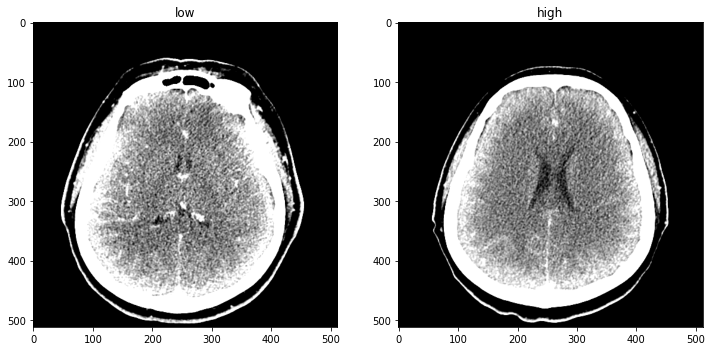

In [22]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[4]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")
print(low.max(), low.min(), low.dtype, low.shape)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [23]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=16, drop_last=False)

CPU 갯수 =  32


## TEST

In [24]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [25]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [26]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [28]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Follow_test_Unet_L1_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    model.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = model(input_low)

        # 저장하기
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/1020 [00:00<?, ?it/s]2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000000.dcm
2741.8494 1.48206 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000000.dcm
Test:   0%|          | 1/1020 [00:02<38:07,  2.25s/it]2728.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000001.dcm
2731.1045 1.0224555 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000001.dcm
Test:   0%|          | 2/1020 [00:02<27:47,  1.64s/it]2720.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000002.dcm
2721.058 -1.5298998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/lo

Test:   2%|▏         | 24/1020 [00:06<02:45,  6.01it/s]2707.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000024.dcm
2706.638 -2.2933853 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000024.dcm
Test:   2%|▏         | 25/1020 [00:06<02:43,  6.07it/s]2740.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000025.dcm
2740.9285 -6.0927505 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000025.dcm
Test:   3%|▎         | 26/1020 [00:06<03:03,  5.41it/s]2760.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000026.dcm
2762.6638 -3.2157674 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

Test:   5%|▍         | 48/1020 [00:10<02:26,  6.64it/s]2568.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000048.dcm
2570.3647 -1.7608005 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000048.dcm
Test:   5%|▍         | 49/1020 [00:10<02:18,  7.00it/s]2551.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000049.dcm
2553.2588 0.13522089 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000049.dcm
Test:   5%|▍         | 50/1020 [00:10<02:20,  6.90it/s]2585.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000050.dcm
2585.493 0.8287771 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L

Test:   7%|▋         | 72/1020 [00:14<02:10,  7.25it/s]2456.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000072.dcm
2446.3953 17.840126 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000072.dcm
Test:   7%|▋         | 73/1020 [00:14<02:20,  6.75it/s]2417.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000073.dcm
2411.1143 20.664265 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/pred_high_000000073.dcm
Test:   7%|▋         | 74/1020 [00:14<02:23,  6.59it/s]2347.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/51545804/gt_low_000000074.dcm
2347.7979 15.346228 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:   9%|▉         | 96/1020 [00:18<02:47,  5.52it/s]2574.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000003.dcm
2569.9595 -0.91261894 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000003.dcm
Test:  10%|▉         | 97/1020 [00:18<02:49,  5.43it/s]2588.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000004.dcm
2587.4944 -1.6763484 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000004.dcm
Test:  10%|▉         | 98/1020 [00:18<02:52,  5.36it/s]2545.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000005.dcm
2547.9656 -0.97144246 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

Test:  12%|█▏        | 120/1020 [00:22<02:10,  6.89it/s]2796.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000027.dcm
2794.8193 -0.73517203 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000027.dcm
Test:  12%|█▏        | 121/1020 [00:22<02:08,  6.99it/s]2847.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000028.dcm
2846.7864 -0.6368074 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000028.dcm
Test:  12%|█▏        | 122/1020 [00:22<02:06,  7.09it/s]2819.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000029.dcm
2819.3076 -2.8640466 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_

Test:  14%|█▍        | 144/1020 [00:25<01:54,  7.64it/s]2158.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000051.dcm
2161.267 3.3985841 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000051.dcm
Test:  14%|█▍        | 145/1020 [00:25<01:57,  7.43it/s]1956.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000052.dcm
1958.3392 2.0740786 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000052.dcm
Test:  14%|█▍        | 146/1020 [00:25<02:00,  7.24it/s]2059.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000053.dcm
2064.6128 1.2649499 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_tes

Test:  16%|█▋        | 168/1020 [00:29<02:26,  5.82it/s]2145.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000075.dcm
2143.8877 2.1493773 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000075.dcm
Test:  17%|█▋        | 169/1020 [00:29<02:41,  5.25it/s]2195.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/gt_low_000000076.dcm
2200.1309 3.1259456 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52079564/pred_high_000000076.dcm
Test:  17%|█▋        | 170/1020 [00:29<02:30,  5.65it/s]2657.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000000.dcm
2657.2048 0.7741029 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet

Test:  19%|█▉        | 192/1020 [00:33<02:30,  5.51it/s]2737.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000022.dcm
2733.9414 -5.4090796 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000022.dcm
Test:  19%|█▉        | 193/1020 [00:34<03:15,  4.22it/s]2771.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000023.dcm
2766.9668 -4.2372465 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000023.dcm
Test:  19%|█▉        | 194/1020 [00:34<03:00,  4.59it/s]2858.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000024.dcm
2857.964 -4.974615 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Une

3184.4658 -2.3512325 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000045.dcm
Test:  21%|██        | 216/1020 [00:37<02:03,  6.52it/s]2761.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000046.dcm
2763.4836 -3.04247 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000046.dcm
Test:  21%|██▏       | 217/1020 [00:37<02:03,  6.52it/s]2738.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000047.dcm
2738.1243 -2.8210883 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000047.dcm
Test:  21%|██▏       | 218/1020 [00:38<02:10,  6.16it/s]2768.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_

Test:  23%|██▎       | 239/1020 [00:41<02:09,  6.02it/s]2350.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000069.dcm
2352.6453 4.0594335 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000069.dcm
Test:  24%|██▎       | 240/1020 [00:41<02:01,  6.44it/s]2289.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000070.dcm
2288.9966 2.6908712 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000070.dcm
Test:  24%|██▎       | 241/1020 [00:41<01:51,  6.98it/s]2169.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000071.dcm
2166.9631 7.275445 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

Test:  26%|██▌       | 263/1020 [00:45<02:28,  5.11it/s]2098.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000093.dcm
2101.7095 6.250793 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000093.dcm
Test:  26%|██▌       | 264/1020 [00:45<02:19,  5.41it/s]2198.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000094.dcm
2200.6648 6.9149375 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/pred_high_000000094.dcm
Test:  26%|██▌       | 265/1020 [00:45<02:20,  5.38it/s]2187.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52100901/gt_low_000000095.dcm
2199.0015 13.390773 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

2728.3147 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000000.dcm
Test:  28%|██▊       | 287/1020 [00:49<02:11,  5.57it/s]2725.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000001.dcm
2719.4314 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000001.dcm
Test:  28%|██▊       | 288/1020 [00:49<02:11,  5.58it/s]2738.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000002.dcm
2738.1375 -5.991945 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000002.dcm
Test:  28%|██▊       | 289/1020 [00:49<02:08,  5.69it/s]2767.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_U

Test:  30%|███       | 310/1020 [00:53<02:19,  5.08it/s]2791.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000024.dcm
2793.006 -5.991945 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000024.dcm
Test:  30%|███       | 311/1020 [00:53<02:17,  5.15it/s]2841.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000025.dcm
2846.9365 -5.991945 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000025.dcm
Test:  31%|███       | 312/1020 [00:54<02:08,  5.53it/s]2958.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000026.dcm
2960.155 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L

Test:  33%|███▎      | 334/1020 [00:57<01:39,  6.90it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000048.dcm
4154.4917 -6.937759 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000048.dcm
Test:  33%|███▎      | 335/1020 [00:57<01:41,  6.78it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000049.dcm
4208.362 -162.87477 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000049.dcm
Test:  33%|███▎      | 336/1020 [00:57<01:39,  6.90it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000050.dcm
4166.802 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000071.dcm
Test:  35%|███▌      | 358/1020 [01:01<01:29,  7.42it/s]2426.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000072.dcm
2424.4136 -49.459114 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000072.dcm
Test:  35%|███▌      | 359/1020 [01:01<01:24,  7.86it/s]2351.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000073.dcm
2346.397 -75.91994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000073.dcm
Test:  35%|███▌      | 360/1020 [01:01<01:28,  7.43it/s]2275.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52

Test:  37%|███▋      | 381/1020 [01:05<01:40,  6.38it/s]2603.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000095.dcm
2596.0786 -123.1401 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000095.dcm
Test:  37%|███▋      | 382/1020 [01:05<01:40,  6.37it/s]2346.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000096.dcm
2344.6882 -111.21234 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/pred_high_000000096.dcm
Test:  38%|███▊      | 383/1020 [01:05<01:35,  6.66it/s]2294.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52347894/gt_low_000000097.dcm
2298.8176 -96.59531 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Une

Test:  40%|███▉      | 405/1020 [01:08<01:49,  5.60it/s]2722.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000008.dcm
2723.8376 -0.83378077 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000008.dcm
Test:  40%|███▉      | 406/1020 [01:08<01:47,  5.74it/s]2707.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000009.dcm
2707.2473 -0.3753966 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000009.dcm
Test:  40%|███▉      | 407/1020 [01:09<02:06,  4.84it/s]2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000010.dcm
2658.7542 -3.1095922 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_

Test:  42%|████▏     | 429/1020 [01:12<01:36,  6.14it/s]2757.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000032.dcm
2758.6682 -2.659751 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000032.dcm
Test:  42%|████▏     | 430/1020 [01:12<01:36,  6.09it/s]2754.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000033.dcm
2753.5212 -4.337564 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000033.dcm
Test:  42%|████▏     | 431/1020 [01:13<01:41,  5.83it/s]2754.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000034.dcm
2750.6387 -3.3370757 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Une

Test:  44%|████▍     | 453/1020 [01:16<01:09,  8.16it/s]2339.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000056.dcm
2335.965 1.9194531 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000056.dcm
Test:  45%|████▍     | 454/1020 [01:16<01:12,  7.77it/s]2289.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000057.dcm
2289.423 -0.79521596 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000057.dcm
Test:  45%|████▍     | 455/1020 [01:16<01:13,  7.69it/s]2099.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000058.dcm
2100.883 -1.2553086 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet

Test:  47%|████▋     | 477/1020 [01:19<01:18,  6.89it/s]2378.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000080.dcm
2364.9758 2.1066632 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000080.dcm
Test:  47%|████▋     | 478/1020 [01:19<01:15,  7.22it/s]2334.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000081.dcm
2334.6912 1.6726873 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/pred_high_000000081.dcm
Test:  47%|████▋     | 479/1020 [01:19<01:17,  6.96it/s]2310.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52351259/gt_low_000000082.dcm
2312.391 2.993898 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000012.dcm
Test:  49%|████▉     | 501/1020 [01:24<01:51,  4.66it/s]2717.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000013.dcm
2715.7466 -5.992677 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000013.dcm
Test:  49%|████▉     | 502/1020 [01:24<01:43,  5.01it/s]2703.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000014.dcm
2700.427 -5.992433 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000014.dcm
Test:  49%|████▉     | 503/1020 [01:24<01:36,  5.37it/s]2710.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/524

Test:  51%|█████▏    | 524/1020 [01:27<01:15,  6.59it/s]2689.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000036.dcm
2694.6604 -5.992433 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000036.dcm
Test:  51%|█████▏    | 525/1020 [01:28<01:17,  6.40it/s]2685.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000037.dcm
2688.7668 -5.992677 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000037.dcm
Test:  52%|█████▏    | 526/1020 [01:28<01:13,  6.69it/s]2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000038.dcm
2677.475 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

2803.415 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000059.dcm
Test:  54%|█████▎    | 548/1020 [01:31<01:14,  6.33it/s]2760.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000060.dcm
2762.9985 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000060.dcm
Test:  54%|█████▍    | 549/1020 [01:31<01:11,  6.63it/s]2758.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000061.dcm
2758.7864 -5.991701 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000061.dcm
Test:  54%|█████▍    | 550/1020 [01:32<01:11,  6.59it/s]2787.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

Test:  56%|█████▌    | 571/1020 [01:35<01:04,  7.00it/s]2359.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000083.dcm
2357.9595 -48.860138 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000083.dcm
Test:  56%|█████▌    | 572/1020 [01:35<01:03,  7.04it/s]2366.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000084.dcm
2367.2947 -50.146446 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000084.dcm
Test:  56%|█████▌    | 573/1020 [01:35<01:03,  7.05it/s]2265.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000085.dcm
2268.0486 -48.563335 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_U

Test:  58%|█████▊    | 595/1020 [01:38<01:09,  6.09it/s]2349.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000107.dcm
2343.021 -114.794235 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000107.dcm
Test:  58%|█████▊    | 596/1020 [01:38<01:06,  6.34it/s]2284.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000108.dcm
2288.3572 -130.99048 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/pred_high_000000108.dcm
Test:  59%|█████▊    | 597/1020 [01:39<01:07,  6.29it/s]2304.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52465336/gt_low_000000109.dcm
2304.1956 -135.55333 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_U

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000000.dcm
Test:  61%|██████    | 619/1020 [01:42<01:17,  5.17it/s]2648.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000001.dcm
2642.2024 -5.991945 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000001.dcm
Test:  61%|██████    | 620/1020 [01:42<01:18,  5.10it/s]2655.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000002.dcm
2653.5164 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000002.dcm
Test:  61%|██████    | 621/1020 [01:42<01:20,  4.97it/s]2627.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52

Test:  63%|██████▎   | 642/1020 [01:46<01:06,  5.65it/s]2743.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000024.dcm
2746.258 -5.991701 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000024.dcm
Test:  63%|██████▎   | 643/1020 [01:46<01:08,  5.53it/s]2746.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000025.dcm
2749.3267 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000025.dcm
Test:  63%|██████▎   | 644/1020 [01:47<01:10,  5.36it/s]2765.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000026.dcm
2770.8433 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

Test:  65%|██████▌   | 666/1020 [01:50<01:06,  5.32it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000048.dcm
4164.046 -5.992189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000048.dcm
Test:  65%|██████▌   | 667/1020 [01:51<01:03,  5.53it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000049.dcm
4265.1636 -203.5997 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000049.dcm
Test:  65%|██████▌   | 668/1020 [01:51<01:00,  5.84it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000050.dcm
4323.405 -438.73196 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_

Test:  68%|██████▊   | 690/1020 [01:54<00:52,  6.34it/s]2357.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000072.dcm
2349.3445 -27.132046 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000072.dcm
Test:  68%|██████▊   | 691/1020 [01:54<00:49,  6.71it/s]2314.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000073.dcm
2320.9868 -27.9546 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000073.dcm
Test:  68%|██████▊   | 692/1020 [01:55<00:50,  6.54it/s]2340.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000074.dcm
2331.1594 -30.619476 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Une

Test:  70%|███████   | 714/1020 [01:58<00:42,  7.20it/s]2460.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000096.dcm
2455.211 -173.19305 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000096.dcm
Test:  70%|███████   | 715/1020 [01:58<00:45,  6.76it/s]2480.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000097.dcm
2478.971 -160.82742 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000097.dcm
Test:  70%|███████   | 716/1020 [01:58<01:08,  4.41it/s]2520.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000098.dcm
2522.7273 -164.66096 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Une

Test:  72%|███████▏  | 738/1020 [02:02<00:41,  6.77it/s]2378.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000120.dcm
2363.999 -168.28166 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000120.dcm
Test:  72%|███████▏  | 739/1020 [02:02<00:40,  6.97it/s]2276.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000121.dcm
2331.4214 -245.09396 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/pred_high_000000121.dcm
Test:  73%|███████▎  | 740/1020 [02:02<00:41,  6.76it/s]2344.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52561195/gt_low_000000122.dcm
2214.2432 -180.10983 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000015.dcm
Test:  75%|███████▍  | 762/1020 [02:06<00:42,  6.02it/s]2890.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000016.dcm
2884.3286 -0.03124237 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000016.dcm
Test:  75%|███████▍  | 763/1020 [02:06<00:39,  6.43it/s]2848.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000017.dcm
2847.96 1.1100805 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000017.dcm
Test:  75%|███████▍  | 764/1020 [02:06<00:37,  6.81it/s]2705.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52

Test:  77%|███████▋  | 785/1020 [02:09<00:33,  7.10it/s]3893.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000039.dcm
3898.8267 0.4566756 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000039.dcm
Test:  77%|███████▋  | 786/1020 [02:09<00:34,  6.87it/s]2827.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000040.dcm
2826.0535 1.2462777 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000040.dcm
Test:  77%|███████▋  | 787/1020 [02:09<00:33,  6.95it/s]2750.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000041.dcm
2750.28 1.2296802 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L

Test:  79%|███████▉  | 809/1020 [02:13<00:36,  5.84it/s]2389.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000063.dcm
2391.4556 0.71051985 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000063.dcm
Test:  79%|███████▉  | 810/1020 [02:13<00:35,  5.90it/s]2407.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000064.dcm
2411.8145 1.4546008 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/pred_high_000000064.dcm
Test:  80%|███████▉  | 811/1020 [02:13<00:34,  6.14it/s]2402.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52584996/gt_low_000000065.dcm
2405.4324 1.4776665 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Une

Test:  82%|████████▏ | 833/1020 [02:17<00:34,  5.43it/s]2673.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000004.dcm
2677.3984 -5.7229676 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000004.dcm
Test:  82%|████████▏ | 834/1020 [02:17<00:32,  5.75it/s]2665.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000005.dcm
2667.3628 -1.2179643 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000005.dcm
Test:  82%|████████▏ | 835/1020 [02:17<00:31,  5.80it/s]2668.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000006.dcm
2670.628 -1.6065413 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

Test:  84%|████████▍ | 857/1020 [02:21<00:26,  6.13it/s]2685.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000028.dcm
2687.7964 -3.0436902 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000028.dcm
Test:  84%|████████▍ | 858/1020 [02:21<00:26,  6.21it/s]2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000029.dcm
2681.8677 -2.368074 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000029.dcm
Test:  84%|████████▍ | 859/1020 [02:21<00:24,  6.60it/s]2720.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000030.dcm
2721.8032 -2.5594335 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000051.dcm
Test:  86%|████████▋ | 881/1020 [02:25<00:19,  6.97it/s]2808.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000052.dcm
2807.9878 -2.5828652 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000052.dcm
Test:  86%|████████▋ | 882/1020 [02:25<00:20,  6.63it/s]2800.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000053.dcm
2799.7666 -2.0805466 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000053.dcm
Test:  87%|████████▋ | 883/1020 [02:25<00:19,  6.88it/s]3011.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/

Test:  89%|████████▊ | 904/1020 [02:28<00:16,  6.94it/s]2491.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000075.dcm
2492.4978 0.92933846 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000075.dcm
Test:  89%|████████▊ | 905/1020 [02:29<00:16,  6.90it/s]2491.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000076.dcm
2484.7998 1.078594 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/pred_high_000000076.dcm
Test:  89%|████████▉ | 906/1020 [02:29<00:17,  6.54it/s]2489.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/52957121/gt_low_000000077.dcm
2486.5134 1.7044177 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet

Test:  91%|█████████ | 928/1020 [02:32<00:15,  6.00it/s]2588.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000003.dcm
2585.419 -0.8115694 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000003.dcm
Test:  91%|█████████ | 929/1020 [02:32<00:16,  5.62it/s]2594.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000004.dcm
2597.002 -0.06394923 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000004.dcm
Test:  91%|█████████ | 930/1020 [02:33<00:15,  5.78it/s]2633.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000005.dcm
2636.1946 -0.9118867 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

Test:  93%|█████████▎| 952/1020 [02:37<00:15,  4.31it/s]2552.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000027.dcm
2558.6052 -9.126433 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000027.dcm
Test:  93%|█████████▎| 953/1020 [02:37<00:13,  4.93it/s]2615.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000028.dcm
2614.7124 -14.022454 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000028.dcm
Test:  94%|█████████▎| 954/1020 [02:37<00:12,  5.27it/s]2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000029.dcm
2627.3752 -6.3885765 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un

Test:  96%|█████████▌| 976/1020 [02:41<00:06,  6.87it/s]2775.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000051.dcm
2775.683 -5.4449596 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000051.dcm
Test:  96%|█████████▌| 977/1020 [02:41<00:06,  7.08it/s]2788.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000052.dcm
2791.863 -6.670002 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000052.dcm
Test:  96%|█████████▌| 978/1020 [02:41<00:05,  7.18it/s]2768.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000053.dcm
2768.68 -5.2701974 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L

Test:  98%|█████████▊| 1000/1020 [02:45<00:03,  5.53it/s]2209.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000075.dcm
2205.3171 6.994508 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000075.dcm
Test:  98%|█████████▊| 1001/1020 [02:45<00:03,  5.70it/s]2197.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000076.dcm
2187.2727 4.5982423 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/pred_high_000000076.dcm
Test:  98%|█████████▊| 1002/1020 [02:45<00:03,  5.60it/s]2237.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_995/low2high/53782539/gt_low_000000077.dcm
2234.0044 2.1004393 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Un